In [2]:
import pandas as pd
import xml.etree.ElementTree as ET

In [13]:
data = pd.read_csv('data/predictions_100_relations.csv')
data = data.drop(['Unnamed: 0.1', 'Unnamed: 0',  'prediction'], axis=1)
data['path'] = data['path'].apply(lambda x: str(x)[60:]) #Only keep the general folder structure

In [14]:
data.head()

,path,sentence,subject,relation,object
0,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,India skipper Virat Kohli on Wednesday credite...,moaning,cause,fuelled
1,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""There is always too much noise and too much c...",spinning,cause,noise
2,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""The reason for our success has been that we h...",cribbed,cause,continue
3,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,England captain Joe Root said Test players sho...,captain,enable,management
4,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""I think that's part and parcel of Test cricke...",noise,cause,opinion


In [15]:
#This could probably be made a lot more efficiently
#Extract the PublicIdentifiers from the files that are in the prediction dataset
paths = data['path'].unique() #Extract all the unique paths
public_ids = {}
for path in paths:
    tree = ET.parse(f"data/{path}")
    f = tree.find('NewsItem') #Traverse down the xml file
    public_ids[path] = list(f.iter('PublicIdentifier'))[0].text

data['PublicID'] = data['path'].map(public_ids)
del public_ids
data.head()

,path,sentence,subject,relation,object,PublicID
0,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,India skipper Virat Kohli on Wednesday credite...,moaning,cause,fuelled,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...
1,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""There is always too much noise and too much c...",spinning,cause,noise,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...
2,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""The reason for our success has been that we h...",cribbed,cause,continue,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...
3,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,England captain Joe Root said Test players sho...,captain,enable,management,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...
4,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""I think that's part and parcel of Test cricke...",noise,cause,opinion,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...


In [16]:
#Add Asrael's URI's to the dataset. Note that some ID's can't be matched
URIs = pd.read_csv("Data/URI_ID.csv")
data = data.join(URIs.set_index('Identifier'), on='PublicID')
data = data.dropna() #For now remove the rows which don't have an URI.
del URIs
data.head()

,path,sentence,subject,relation,object,PublicID,URI
34,afp_2021/2021/03/03/afp.com-20210303T213355Z-T...,Brazil registered a record of Covid-19 deaths ...,registered,cause,lost,urn:newsml:afp.com:20210303T213355Z:TX-PAR-TWM...,http://asrael.eurecom.fr/news/9cd8075b-2e65-36...
35,afp_2021/2021/03/03/afp.com-20210303T213355Z-T...,With a surge in cases currently pushing health...,surge,cause,recorded,urn:newsml:afp.com:20210303T213355Z:TX-PAR-TWM...,http://asrael.eurecom.fr/news/9cd8075b-2e65-36...
36,afp_2021/2021/03/03/afp.com-20210303T074352Z-T...,At least 10 rockets hit a military base in wes...,visit,cause,hit,urn:newsml:afp.com:20210303T074352Z:TX-PAR-TVP...,http://asrael.eurecom.fr/news/35f2598c-5036-34...
37,afp_2021/2021/03/03/afp.com-20210303T074352Z-T...,The Ain al-Assad base hosts Iraqi forces as we...,coalition,enable,fight,urn:newsml:afp.com:20210303T074352Z:TX-PAR-TVP...,http://asrael.eurecom.fr/news/35f2598c-5036-34...
38,afp_2021/2021/03/03/afp.com-20210303T074352Z-T...,Coalition spokesman Colonel Wayne Marotto conf...,hit,cause,provide,urn:newsml:afp.com:20210303T074352Z:TX-PAR-TVP...,http://asrael.eurecom.fr/news/35f2598c-5036-34...


In [22]:
#Create a graph based on the created dataframe

from rdflib import Graph, Literal, RDF, URIRef, OWL, Namespace
from resources import *

rnews = Namespace("http://iptc.org/std/rNews/2011-10-07#")
nif = Namespace("http://persistence.uni-leipzig.org/nlp2rdf/ontologies/nif-core#")
faro = Namespace("https://purl.org/faro/")

faro_classes = {'cause': faro.causes, 'enable': faro.enables, 'intend': faro.intends_to_cause, 'prevent': faro.prevents} #dict of faro definitions

graph = Graph()

for index, row in data.iterrows():

    graph.add((URIRef(row['URI']), RDF.type, rnews.Article)) #Add the URI as article
    graph.add((URIRef(row['URI']), rnews.identifier, Literal(row['PublicID']))) #Link the PublicID to the article
    sentence_uri = node_creation('', row['sentence'], base_add='/sentence') #Generate the URI for the sentence
    graph.add((URIRef(row['URI']), nif.sentence, sentence_uri)) #Link the article to the sentence
    graph.add((sentence_uri, RDF.type, nif.Sentence)) #Make the sentence URI of class 'Sentence'
    graph.add((sentence_uri, RDF.value, Literal(row['sentence']))) #Set the value of the URI equal to the sentence

    subject_uri = node_creation('', row['subject'] + str(sentence_uri), base_add='/subject') #Generate the URI for the subject, for now add the uri of sentence to make it unique
    graph.add((sentence_uri, faro.Relata, subject_uri)) #Add the subject to the sentence
    graph.add((subject_uri, RDF.value, Literal(row['subject']))) #Set the value of the subject URI equal to the subject

    object_uri = node_creation('', row['object'] + str(sentence_uri), base_add='/object') #Generate the URI for the object, for now add the uri of sentence to make it unique
    graph.add((sentence_uri, faro.Relata, object_uri)) #Add the object to the sentence
    graph.add((object_uri, RDF.value, Literal(row['object']))) #Set the value of the subject URI equal to the object

    graph.add((subject_uri, faro_classes[row['relation']], object_uri)) #Add relation betwee NERs

graph.serialize('Data/examples/first_sentence_ner.ttl', format='turtle')

<Graph identifier=Na6cbd695764a4a6bbaa3011b53e0a71e (<class 'rdflib.graph.Graph'>)>

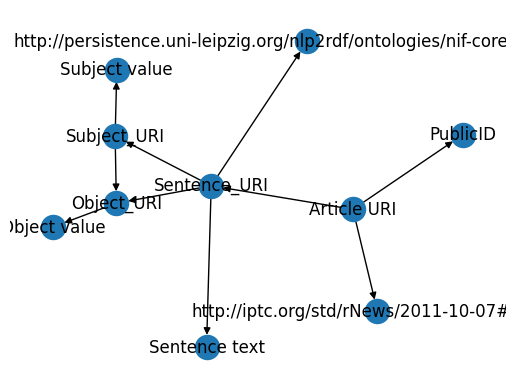

In [38]:
import networkx as nx
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph

nx_graph = rdflib_to_networkx_multidigraph(graph)
pos = nx.spring_layout(nx_graph, scale=2)

edge_labels = nx.get_edge_attributes(nx_graph, 'r')
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels)
nx.draw(nx_graph, with_labels=True)